# Exploratory Data Analysis - Sales

In [1]:
import pandas as pd
import numpy as np
import datetime
import time

import matplotlib.pyplot as plt
import seaborn as sns

import requests

pd.options.display.max_columns = None

## Load Data

In [2]:
sales = pd.read_csv("./data/sales_parcels_181920.csv")
sales["Year"] = sales["dateYM"].apply(lambda x: x[:4])
sales

,parcel,dateYM,LpriceUSD,x,y,road,distRoad,distPlaza,distOrigin,payMANA,payETH,YM_2018-11,YM_2018-12,YM_2019-01,YM_2019-02,YM_2019-03,YM_2019-04,YM_2019-05,YM_2019-06,YM_2019-07,YM_2019-08,YM_2019-09,YM_2019-10,YM_2019-11,YM_2019-12,YM_2020-01,YM_2020-02,YM_2020-03,YM_2020-04,YM_2020-05,YM_2020-06,YM_2020-07,YM_2020-08,YM_2020-09,YM_2020-10,YM_2020-11,YM_2020-12,Year
0,1157920892373161954235709850086879078195820303...,2020-02,11.103402,-100,-140,0,0.497628,0.594507,0.760286,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2020
1,1157920892373161954235709850086879078195820303...,2020-07,10.876604,-100,-150,0,0.586722,0.668441,0.796660,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2020
2,1157920892373161954235709850086879078195820303...,2019-12,11.891910,-100,-21,0,0.009929,0.108037,0.451546,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2019
3,1157920892373161954235709850086879078195820303...,2019-12,10.879684,-100,-60,0,0.009929,0.230347,0.515348,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2019
4,1157920892373161954235709850086879078195820303...,2019-12,11.102952,-100,-60,0,0.009929,0.230347,0.515348,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6102,3062541302288446171170371466885913903128,2019-12,11.037419,9,24,0,0.079430,0.119145,0.113270,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2019
6103,3062541302288446171170371466885913903129,2019-10,10.733785,9,25,0,0.079430,0.127088,0.117418,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2019
6104,3062541302288446171170371466885913903129,2020-08,10.244236,9,25,0,0.079430,0.127088,0.117418,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2020
6105,3062541302288446171170371466885913903129,2020-08,10.400880,9,25,0,0.079430,0.127088,0.117418,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2020


## Descriptive Statistics

### Selling Price Trend

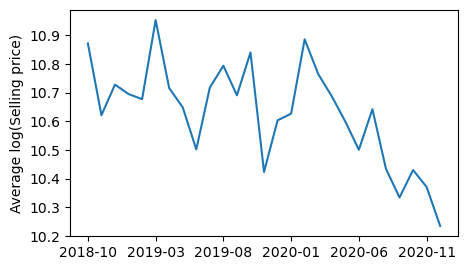

In [7]:
plt.rcParams["figure.figsize"] = (5,3); plt.rcParams["figure.dpi"] = 100
sales.groupby("dateYM")["LpriceUSD"].mean().plot()
plt.ylabel("Average log(Selling price)")
plt.xlabel("")
plt.savefig("./figures/sales_yearmonth.png")
# plt.show()

### Selling Price by Year

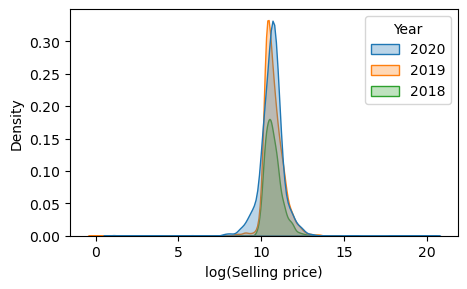

In [8]:
# log-transformed selling prices in USD
plt.rcParams["figure.figsize"] = (5,3); plt.rcParams["figure.dpi"] = 100
sns.kdeplot(data=sales, x="LpriceUSD", hue="Year", fill=True, alpha=.3)
plt.xlabel("log(Selling price)")
plt.savefig("./figures/sales_year.png")
# plt.show()

### Yearly Average Selling Price by Parcel

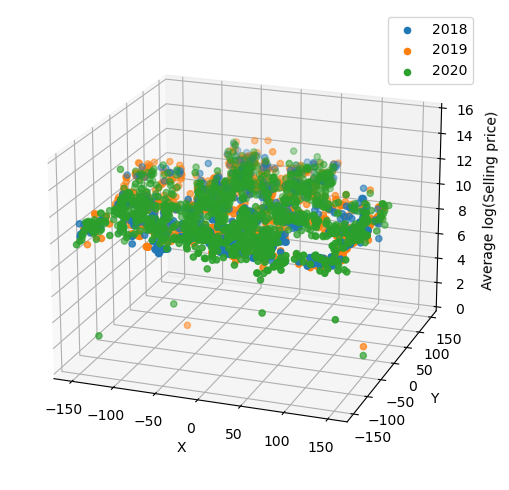

In [9]:
fig = plt.figure(figsize=(5,5)); plt.rcParams["figure.dpi"] = 100
ax = plt.axes(projection="3d")

for y in [2018,2019,2020]:
    tmp = sales[sales.Year==str(y)].groupby(["x","y"])["LpriceUSD"].mean().to_frame("AVG_LpriceUSD").reset_index()
    ax.scatter3D(tmp.x, tmp.y, tmp["AVG_LpriceUSD"], label=str(y))

ax.set_xlabel("X"); ax.set_ylabel("Y")
ax.set_zlabel("Average log(Selling price)")
ax.set_zlim(0,16)
ax.view_init(20, 290)

plt.legend(); plt.tight_layout()
plt.savefig("sales_parcels.png", dpi=300)
# plt.show()

## Pricing Models

### Hedonic Regression Model

$$\begin{equation}
\begin{split}
    \log{(Selling \text{ } price_{it})} &= \alpha + X_{i} \beta + \delta_{t} + \epsilon_{it}
\end{split}
\end{equation}$$

In [10]:
import statsmodels.api as sm
from linearmodels import PanelOLS

In [11]:
sales["dateYM"] = sales["dateYM"].apply(lambda x: datetime.datetime.strptime(str(x), "%Y-%m"))
sales = sales.set_index(["parcel","dateYM"])

In [12]:
X = sm.add_constant(sales.drop(columns=["LpriceUSD","Year","x","y"]))
y = sales.LpriceUSD
result = PanelOLS(y, X, entity_effects=False).fit(cov_type="clustered", cluster_entity=True)
print(result)

                          PanelOLS Estimation Summary                           
Dep. Variable:              LpriceUSD   R-squared:                        0.2280
Estimator:                   PanelOLS   R-squared (Between):              0.2850
No. Observations:                6107   R-squared (Within):               0.1666
Date:                Wed, Mar 16 2022   R-squared (Overall):              0.2280
Time:                        18:52:22   Log-likelihood                   -6485.1
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      56.062
Entities:                        3284   P-value                           0.0000
Avg Obs:                       1.8596   Distribution:                 F(32,6074)
Min Obs:                       1.0000                                           
Max Obs:                       23.000   F-statistic (robust):             43.163
                            

C:\Users\user\anaconda3\lib\site-packages\linearmodels\panel\data.py:98: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(s):


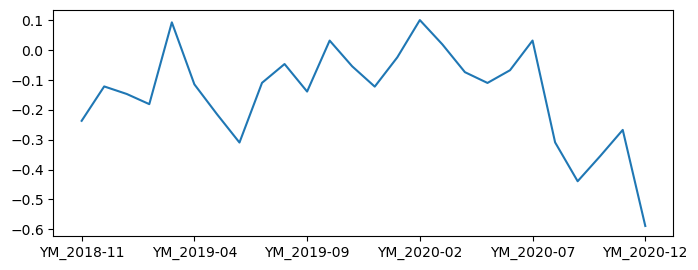

In [13]:
plt.rcParams["figure.figsize"] = (8,3)
result.params[[c for c in result.params.index if "YM_" in c]].plot()
plt.show()

In [14]:
sales["LpriceUSD_pred"] = result.predict(sm.add_constant(sales.drop(columns=["LpriceUSD","Year","x","y"])))

C:\Users\user\anaconda3\lib\site-packages\linearmodels\panel\data.py:98: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(s):


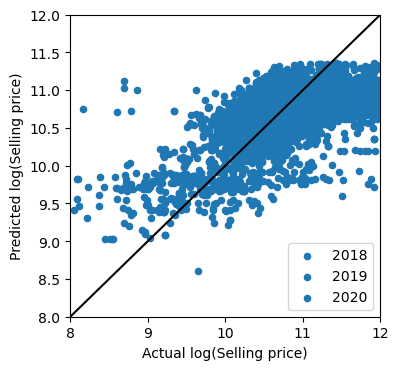

In [15]:
plt.rcParams["figure.figsize"] = (4,4); fig, ax = plt.subplots()

for y in [2018,2019,2020]:
    sales[sales.Year==str(y)].plot(x="LpriceUSD", y="LpriceUSD_pred", kind="scatter", ax=ax, label=str(y))

ax.axline([0, 0], [1, 1], c="black")
ax.set_xlim([8,12]); ax.set_ylim([8,12])
ax.set_xlabel("Actual log(Selling price)"); ax.set_ylabel("Predicted log(Selling price)")
plt.legend()
plt.savefig("./figures/eval_hedonic.png")
# plt.show()